In [1]:

# import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import cv2
from PIL import Image

In [2]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True, autoshape=False)
model.eval()

Using cache found in C:\Users\prana/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-3-19 Python-3.11.1 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)



DetectMultiBackend(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, tr

In [3]:
# image_id = '000000000662'
image_id = '000000000139'
image_path = f'C:/Users/prana/fiftyone/coco-2017/validation/data/{image_id}.jpg'

transform = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize to YOLOv5 input size
    transforms.ToTensor()
])
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
input_tensor.requires_grad = True  # Enable gradients


In [4]:
# model.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(model.device)

#check device of model
print(model.device)

#check device of input tensor
print(input_tensor.device)

cuda:0
cpu


In [5]:
input_tensor = input_tensor.to(model.device)

In [6]:
# Perform inference
output = model(input_tensor)  # Get detections  
len(output)  # Print results

2

In [7]:
output[0].shape, len(output[1])

(torch.Size([1, 25200, 85]), 3)

In [8]:
output[1][0].shape, output[1][1].shape, output[1][2].shape

(torch.Size([1, 3, 80, 80, 85]),
 torch.Size([1, 3, 40, 40, 85]),
 torch.Size([1, 3, 20, 20, 85]))

<h1> Evaluation </h1>

In [ ]:
from ultralytics import YOLO  # Import the YOLOv8 library
import fiftyone as fo
import fiftyone.zoo as foz
from collections import defaultdict
from PIL import Image
import numpy as np
import cv2
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


# Load Dataset
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    max_samples = 1000,
    label_types=["detections"],
    )

In [ ]:
with open("instances_val2017.json") as f:
    ground_truth = json.load(f)
    
gt_categories = ground_truth['categories']

# COCO mapping from category name to category id
gt = defaultdict(list)
for category in gt_categories:
    gt[category['name']] = category['id']

# COCO mapping from category id to category name
gt_rev = {v: k for k, v in gt.items()}

# YOLO mapping from class index to class name
yolo_classes = {
    0: "person", 1: "bicycle", 2: "car", 3: "motorcycle", 4: "airplane", 5: "bus", 6: "train", 7: "truck", 
    8: "boat", 9: "traffic light", 10: "fire hydrant", 11: "stop sign", 12: "parking meter", 13: "bench", 
    14: "bird", 15: "cat", 16: "dog", 17: "horse", 18: "sheep", 19: "cow", 20: "elephant", 21: "bear", 
    22: "zebra", 23: "giraffe", 24: "backpack", 25: "umbrella", 26: "handbag", 27: "tie", 28: "suitcase", 
    29: "frisbee", 30: "skis", 31: "snowboard", 32: "sports ball", 33: "kite", 34: "baseball bat", 
    35: "baseball glove", 36: "skateboard", 37: "surfboard", 38: "tennis racket", 39: "bottle", 
    40: "wine glass", 41: "cup", 42: "fork", 43: "knife", 44: "spoon", 45: "bowl", 46: "banana", 
    47: "apple", 48: "sandwich", 49: "orange", 50: "broccoli", 51: "carrot", 52: "hot dog", 53: "pizza", 
    54: "donut", 55: "cake", 56: "chair", 57: "couch", 58: "potted plant", 59: "bed", 60: "dining table", 
    61: "toilet", 62: "tv", 63: "laptop", 64: "mouse", 65: "remote", 66: "keyboard", 67: "cell phone", 
    68: "microwave", 69: "oven", 70: "toaster", 71: "sink", 72: "refrigerator", 73: "book", 74: "clock", 
    75: "vase", 76: "scissors", 77: "teddy bear", 78: "hair drier", 79: "toothbrush"
}


In [ ]:
model_names = [
    "yolov5s",
    "yolov8s",
    "yolov8x",
    "yolov9e",
    "yolov10b",
    "yolov10x",
    "yolo11n",
    "yolo11m",
    "yolo11x",
]

In [ ]:
# Load the YOLO model
name = model_names[0]
model = YOLO(f'{name}.pt')  # Use the YOLO model

predictions = []

for sample in dataset:
    image_id = int(sample.filepath.split('\\')[-1].split('.')[0])
    image = Image.open(sample.filepath)

    # Perform inference
    results = model.predict(image, imgsz=640)  # Specify the input size if needed
    detections = results[0].boxes  # Extract bounding boxes

    # Convert detections to the required format
    for detection in detections:
        x1, y1, x2, y2 = detection.xyxy[0].tolist()  # Bounding box coordinates
        conf = detection.conf[0].item()  # Confidence score
        cls = int(detection.cls[0].item())  # Class index
        width, height = x2 - x1, y2 - y1
        predictions.append({
            "image_id": image_id,
            "category_id": gt[yolo_classes[cls]],
            "bbox": [float(x1), float(y1), float(width), float(height)],
            "score": float(conf)
        })

# Save predictions
with open(f"predictions_{name}.json", "w") as f:
    json.dump(predictions, f, indent=4)


In [ ]:
# Load ground truth
coco_gt = COCO("instances_val2017.json")

# Load predictions
coco_dt = coco_gt.loadRes(f"predictions_{name}.json")
imgIds=sorted(coco_gt.getImgIds())
imgIds=imgIds[0:1000]
imgId = imgIds[np.random.randint(1000)]

# Run COCO evaluation
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.params.imgIds  = imgIds
coco_eval.evaluate()  # Ensure evaluation runs
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=1.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.90s).
Accumulating evaluation results...
DONE (t=0.50s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.645
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.559
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.663
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.389
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.568
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [ ]:
import matplotlib.pyplot as plt
  
bbox =  [
        7.03,
        167.76,
        149.32,
        94.87
      ]

cls = gt_rev[72]

x1, y1, x2, y2 = bbox
image_id = '000000000139'
image_path = f'C:/Users/prana/fiftyone/coco-2017/validation/data/{image_id}.jpg'
image_cv = cv2.imread(image_path)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
cv2.rectangle(image_cv, (int(x1), int(y1)), (int(x1+x2), int(y1+y2)), (255, 0, 0), 2)
cv2.putText(image_cv, f"{cls} {conf:.2f}", (int(x1), int(y1) - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Show image with detections
plt.figure(figsize=(10, 6))
plt.imshow(image_cv)
plt.axis("off")
plt.savefig("output.jpeg")

<h1> Faster RCNN evaluation </h1>

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import json
from collections import defaultdict
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import fiftyone.zoo as foz
import sys
import io

# Load Dataset
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    max_samples = 1000,
    label_types=["detections"],
    )

# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True, require_grad=True)
model.eval()

# Define image transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

with open("instances_val2017.json") as f:
    ground_truth = json.load(f)
    
gt_categories = ground_truth['categories']

# COCO mapping from category name to category id
gt = defaultdict(list)
for category in gt_categories:
    gt[category['name']] = category['id']

# COCO mapping from category id to category name
gt_rev = {v: k for k, v in gt.items()}

Found annotations at 'C:\Users\prana\fiftyone\coco-2017\raw\instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████| 1000/1000 [9.8s elapsed, 0s remaining, 111.5 samples/s]      
Dataset 'coco-2017-validation-1000' created


c:\Users\prana\OneDrive\Desktop\IITHyderabad\Computer vision\Project\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prana\OneDrive\Desktop\IITHyderabad\Computer vision\Project\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
from tqdm import tqdm

predictions = []


# Load and preprocess image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0), image

# Perform inference
def detect_objects(image_path, threshold=0.5):
    image_tensor, image = load_image(image_path)
    
    with torch.no_grad():
        predictions = model(image_tensor)[0]
    
    # Extract boxes, labels, and scores
    boxes = predictions['boxes'].cpu().numpy()  # Convert to NumPy
    labels = predictions['labels'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()
    
    # Filter based on threshold
    valid_indices = scores > threshold
    filtered_boxes = boxes[valid_indices]
    filtered_labels = labels[valid_indices]
    filtered_scores = scores[valid_indices]
    
    return image, filtered_boxes, filtered_labels, filtered_scores


for sample in tqdm(dataset):
    
    # Get image ID from the sample filepath
    image_id = int(sample.filepath.split('\\')[-1].split('.')[0])
    image_path = sample.filepath
    image, boxes, labels, scores = detect_objects(image_path)
    # Convert boxes to COCO format
    for i, bbox in enumerate(boxes):
        # Convert from (x1, y1, x2, y2) to (x, y, width, height)
        x1, y1, x2, y2 = bbox
        conf = scores[i]
        cls = labels[i]
        width, height = x2 - x1, y2 - y1
        # Convert class index to COCO category ID
        predictions.append({
            "image_id": image_id,
            "category_id": int(cls),
            "bbox": [float(x1), float(y1), float(width), float(height)],
            "score": float(conf)
        })
        
# Save predictions
with open(f"predictions_faster_rcnn.json", "w") as f:
    json.dump(predictions, f, indent=4)        

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [32:46<00:00,  1.97s/it]


In [ ]:
# Load ground truth
coco_gt = COCO("instances_val2017.json")

# Load predictions
coco_dt = coco_gt.loadRes(f"predictions_faster_rcnn.json")
imgIds=sorted(coco_gt.getImgIds())
imgIds=imgIds[0:1000]
imgId = imgIds[np.random.randint(1000)]

# Run COCO evaluation
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.params.imgIds  = imgIds
coco_eval.evaluate()  # Ensure evaluation runs
coco_eval.accumulate()
output_buffer = io.StringIO()
sys.stdout = output_buffer

# Run COCO evaluation and print results
coco_eval.summarize()

# Restore stdout
sys.stdout = sys.__stdout__

# Save the captured output to a file
with open(f"evaluation/baseline/evaluation_results_faster_rcnn.txt", "w") as f:
    f.write(output_buffer.getvalue())

# Optionally, print a message to confirm
print(f"Evaluation results saved to evaluation_results_faster_rcnn.txt")

loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.20s).
Accumulating evaluation results...


DONE (t=0.53s).


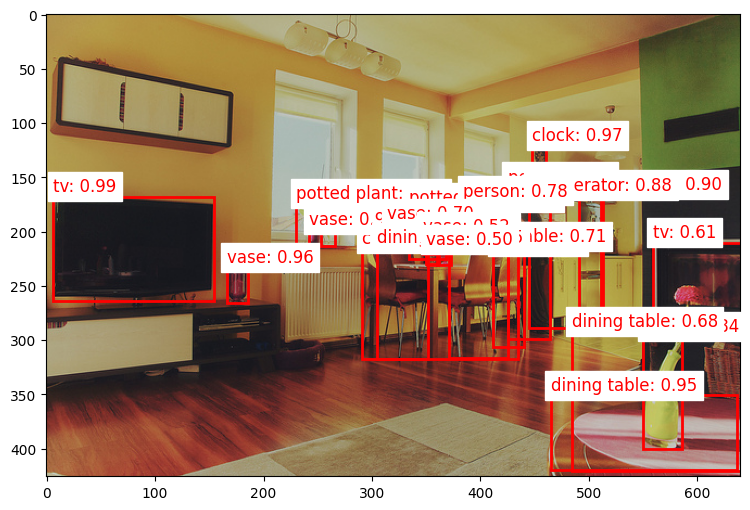

In [12]:
def plot_detections(image, boxes, labels, scores):
    fig, ax = plt.subplots(1, figsize=(10, 6))

    # Convert PIL image to NumPy array
    image_np = np.array(image)
    ax.imshow(image_np)

    for box, label, score in zip(boxes, labels, scores):
        x_min, y_min, x_max, y_max = [int(coord) for coord in box]  # Ensure integers
        width, height = x_max - x_min, y_max - y_min

        # Get class name from COCO labels
        class_name = gt_rev[label]

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, f'{class_name}: {score:.2f}', color='red', fontsize=12, backgroundcolor='white')

    plt.show(block=True)  # Force blocking display


# Example usage
image_id = '000000000139'
image_path = f'C:/Users/prana/fiftyone/coco-2017/validation/data/{image_id}.jpg'
image, boxes, labels, scores = detect_objects(image_path)
plot_detections(image, boxes, labels, scores)